In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
plants = pd.read_csv('data/plants/plants.csv', sep = ';', index_col = 0, comment = '#')

for i in plants.index:
    pv_ninja = pd.read_csv('data/solar/ninja_pv_%s.csv'%plants['location'][i],
                           sep = ',',
                           index_col = 0,
                           usecols = [0,2],
                           comment = '#')
    P = pv_ninja['electricity'].values/pv_ninja['electricity'].mean()*plants['atlas_solar_power'][i]/8760
    cf_pv = P/1000
    pd.Series(cf_pv).to_csv('data/cf/pv_%s.csv'%plants['location'][i])

In [3]:
# abandoned
###############################
# irradiance method
pvtype = '0single'

phi = 56.4 # Latitude 
xi = 6.8 # Longitude

d_n = np.arange(1,366)
d_n = np.repeat(d_n,24) # Number of the day
LT = np.arange(0,24)
LT = np.tile(LT,365) # Hour of day in UTC
B = (d_n-81)*360/365
ET = 9.87*np.sin(2*np.deg2rad(B))-7.53*np.cos(np.deg2rad(B))-1.5*np.sin(np.deg2rad(B))
ST = LT+(ET/60)-(xi/15)
omega = 15*(ST-12)
delta = 23.45*np.sin(np.deg2rad(360*(d_n+284)/365))

singamma_s = (np.sin(np.deg2rad(delta))*np.sin(np.deg2rad(phi))
              +np.cos(np.deg2rad(delta))*np.cos(np.deg2rad(phi))*np.cos(np.deg2rad(omega)))
cosgamma_s = np.cos(np.arcsin(singamma_s))

cospsi_s = (singamma_s*np.sin(np.deg2rad(phi))-np.sin(np.deg2rad(delta)))/cosgamma_s/np.cos(np.deg2rad(phi))
psi_s = np.arccos(cospsi_s)*(omega<0)-np.arccos(cospsi_s)*(omega>=0)

In [4]:
B0 = 1.367 # kW/m2
epsilon = 1+0.033*np.cos(np.deg2rad(360*d_n/365))
B0t = B0*epsilon*singamma_s
B0t[B0t<0] = 0

# Ground-level solar irradiance (kW/m2)
G_0 = pd.read_csv('data/solar/Global_irr_pv_56.4000_6.8000.csv',
                  sep = ',',
                  index_col = 0,
                  usecols = [0,2],
                  comment = '#')['radiation_surface'].values/1000

# plot font size
plt.rcParams.update({'font.size': 18})

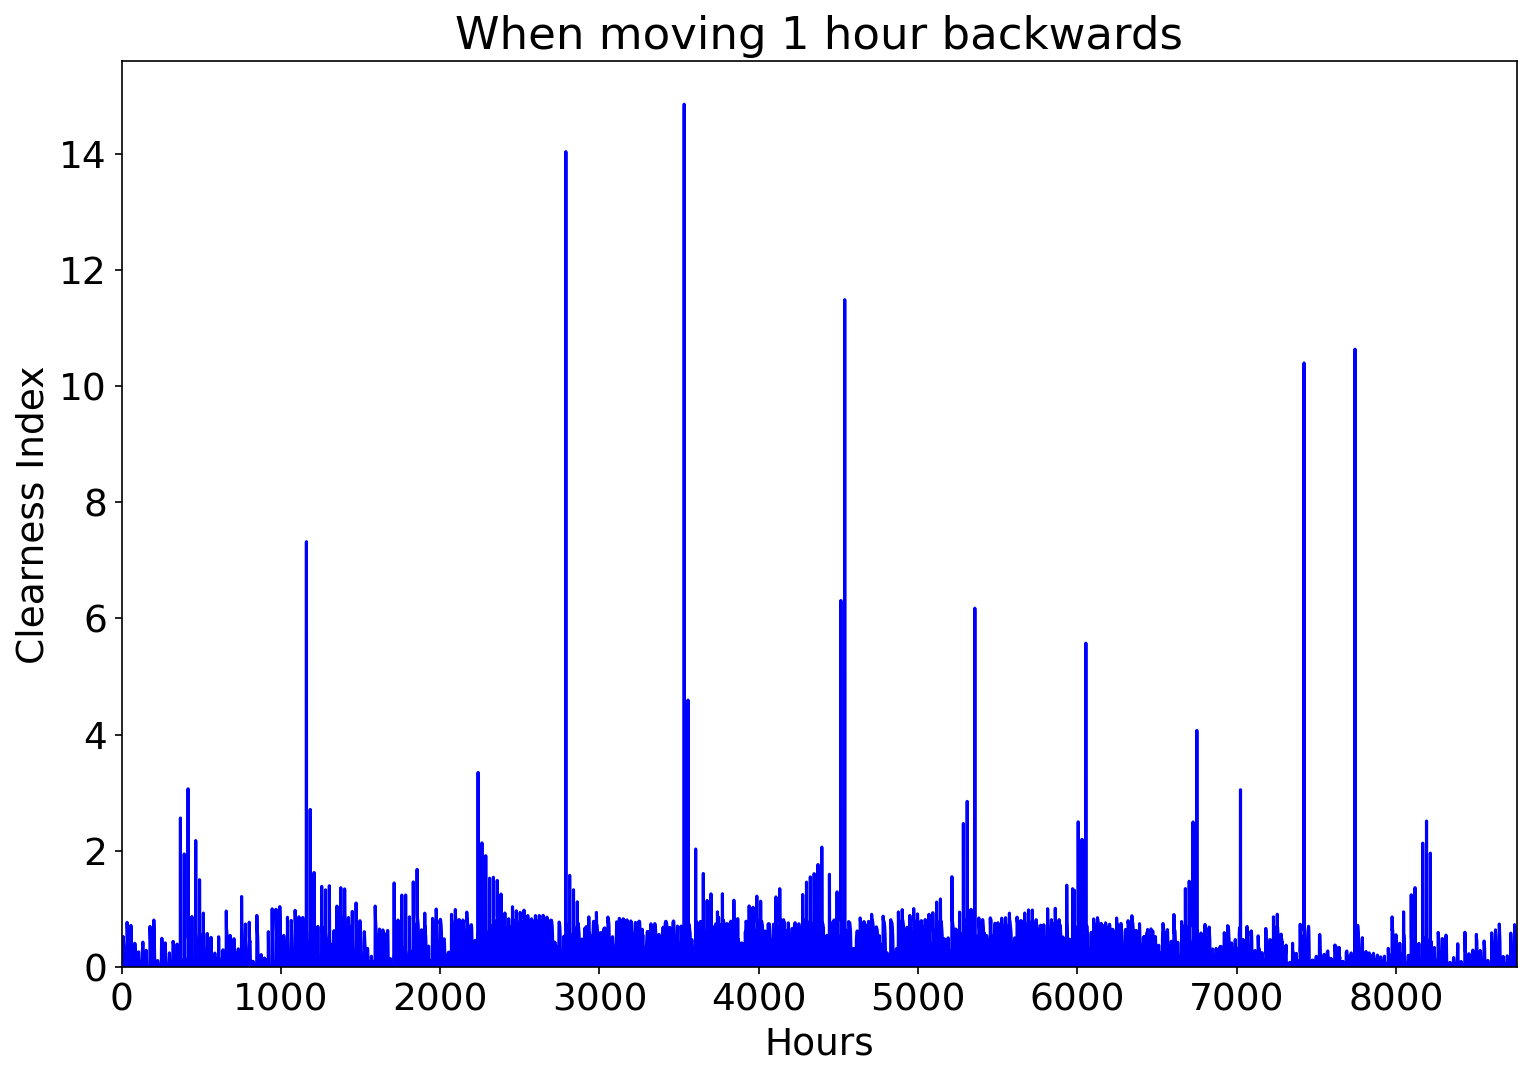

2019-01-16 09:00:00
2019-01-17 09:00:00
2019-01-18 09:00:00
2019-01-20 09:00:00
2019-01-21 09:00:00
2019-02-01 09:00:00
2019-02-09 09:00:00
2019-02-11 09:00:00
2019-02-18 08:00:00
2019-02-19 08:00:00
2019-02-20 08:00:00
2019-02-22 08:00:00
2019-02-23 08:00:00
2019-02-24 08:00:00
2019-02-26 08:00:00
2019-02-27 08:00:00
2019-02-28 08:00:00
2019-03-03 08:00:00
2019-03-08 08:00:00
2019-03-13 07:00:00
2019-03-15 07:00:00
2019-03-16 07:00:00
2019-03-18 07:00:00
2019-03-19 07:00:00
2019-04-04 06:00:00
2019-04-05 06:00:00
2019-04-06 06:00:00
2019-04-07 06:00:00
2019-04-08 06:00:00
2019-04-09 06:00:00
2019-04-10 06:00:00
2019-04-13 06:00:00
2019-04-27 05:00:00
2019-04-28 05:00:00
2019-04-29 05:00:00
2019-04-30 05:00:00
2019-05-28 04:00:00
2019-05-29 04:00:00
2019-05-31 04:00:00
2019-06-02 04:00:00
2019-06-03 04:00:00
2019-06-04 04:00:00
2019-06-07 04:00:00
2019-06-10 04:00:00
2019-06-14 04:00:00
2019-06-15 04:00:00
2019-06-16 04:00:00
2019-06-17 04:00:00
2019-06-21 04:00:00
2019-06-22 04:00:00


In [5]:
n = -1 # integer
if n < 0:
    title = f'When moving {-n} hours backwards' if n != -1 else f'When moving {-n} hour backwards'
elif n > 0:
    title = f'When moving {n} hours forwards' if n != 1 else f'When moving {n} hour forwards'
else:
    title = 'Original'
    
K_t = np.divide(np.concatenate((G_0[n:],G_0[:n])), B0t, out = np.zeros_like(G_0), where = B0t!=0)

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12,8), dpi = 150)
ax.plot(K_t, c = 'blue')
ax.set_xlim(0,8759)
ax.set_ylim(0)
ax.set_title(title)
ax.set_xlabel('Hours')
ax.set_ylabel('Clearness Index')
plt.show()

t = pd.date_range('2019-01-01 00:00', '2019-12-31 23:00', freq = 'H')
for i in t[np.where(K_t>1)]:
    print(i)
print(len(K_t[K_t>1]))